# Single cell trajectory of monocytes/macrphages in bronchoalveolar lavage of COVID19 patients

In [17]:
# load libraries
library(monocle)

In [19]:
# load data
expression<-read.table("mono_counts.txt",h=T)
meta<-read.table("meta.txt",h=T)

In [29]:
# Create monocle single cell object with matrix (expression) and meta data (meta)
mat<-as.matrix(expression)
colonnes<-as.data.frame(colnames(mat))
colonnes$group<-meta$group
colnames(colonnes)<-c("id","group")
row.names(colonnes)<-colonnes$id
pd <- new("AnnotatedDataFrame", data = colonnes)

genes<-as.data.frame(row.names(mat))
colnames(genes)<-"gene_short_name"
row.names(genes)<-genes$gene_short_name
fd <- new("AnnotatedDataFrame", data = genes)
cds <- newCellDataSet(mat, phenoData = pd,featureData = fd)
cds

CellDataSet (storageMode: environment)
assayData: 23742 features, 1693 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: ct51_ACGAGGAGTAATCGTC.1 ct51_ACGATACCATGATCCA.1 ...
    sc146_TTTACTGTCGAATCCA.1 (1693 total)
  varLabels: id group Size_Factor
  varMetadata: labelDescription
featureData
  featureNames: AL627309.1 AL669831.5 ... AF127577.3 (23742 total)
  fvarLabels: gene_short_name
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

In [31]:
# defined cell hierarchy on makers expression
cth <- newCellTypeHierarchy()
NFKBIA_id <- row.names(subset(fData(cds), gene_short_name == "NFKBIA"))
cth <- addCellType(cth, "NFKBIA_HIGH", classify_func = function(x) { x[NFKBIA_id,] >= 8})
cth <- addCellType(cth, "NFKBIA_MEDIUM", classify_func = function(x) { x[NFKBIA_id,] < 8 & x[NFKBIA_id,] > 3} )
cth <- addCellType(cth, "NFKBIA_LOW", classify_func = function(x) { x[NFKBIA_id,] <= 3 })
cds <- classifyCells(cds, cth)
table(pData(cds)$CellType)


  NFKBIA_HIGH    NFKBIA_LOW NFKBIA_MEDIUM 
          639           708           346 

In [34]:
# object transformations
cds@expressionFamily = negbinomial.size()
cds@lowerDetectionLimit = 0
my_feat <- fData(cds)
my_feat$id<-my_feat$gene_short_name
head(my_feat)

,gene_short_name,id
,<chr>,<chr>
AL627309.1,AL627309.1,AL627309.1
AL669831.5,AL669831.5,AL669831.5
FAM87B,FAM87B,FAM87B
LINC00115,LINC00115,LINC00115
FAM41C,FAM41C,FAM41C
NOC2L,NOC2L,NOC2L


In [36]:
# size factor and dispersion
cds <- estimateSizeFactors(cds)
cds <- estimateDispersions(cds)

Warning message in if (isSparseMatrix(counts)) {:
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (isSparseMatrix(exprs(cds))) {:
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Removing 55 outliers




FALSE  TRUE 
 9637  7737 

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


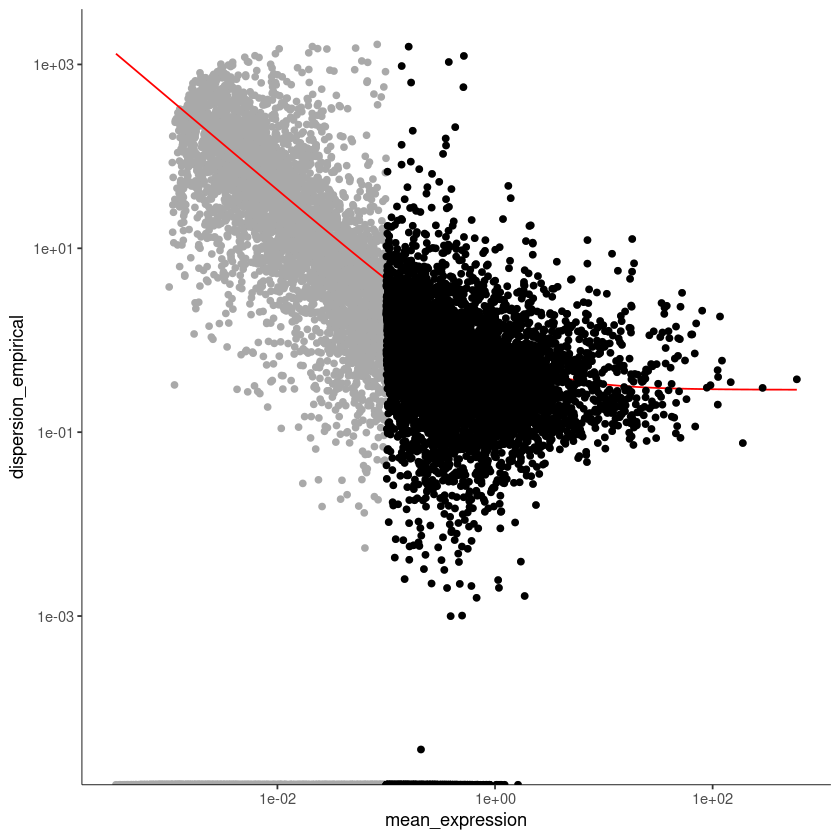

In [37]:
# dispersion table and variance 
disp_table <- dispersionTable(cds)
table(disp_table$mean_expression>=0.1)
unsup_clustering_genes <- subset(disp_table, mean_expression >= 0.1)
cds <- setOrderingFilter(cds, unsup_clustering_genes$gene_id)
plot_ordering_genes(cds)

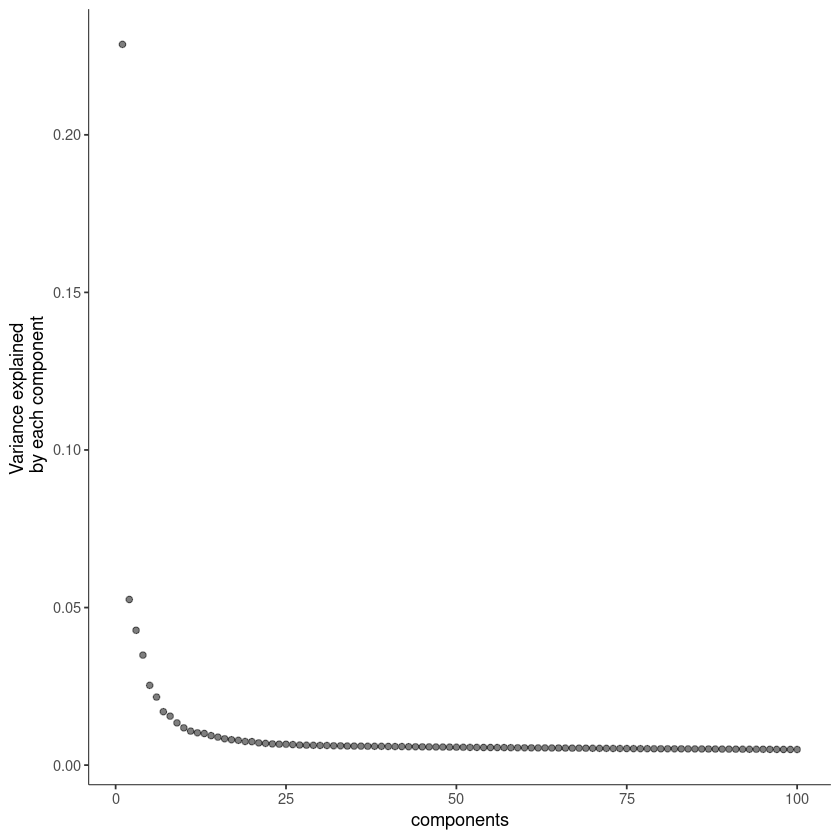

In [38]:
# plot variance
plot_pc_variance_explained(cds, return_all = FALSE)

In [39]:
# reduce dimensions by tsne
cds <- reduceDimension(cds, max_components = 2, num_dim = 10, reduction_method = 'tSNE', verbose = TRUE)

Remove noise by PCA ...

Reduce dimension by tSNE ...



In [40]:
# clustering cells
cds <- clusterCells(cds)
table(pData(cds)$CellType)

Distance cutoff calculated to 3.466849 



  NFKBIA_HIGH    NFKBIA_LOW NFKBIA_MEDIUM 
          639           708           346 

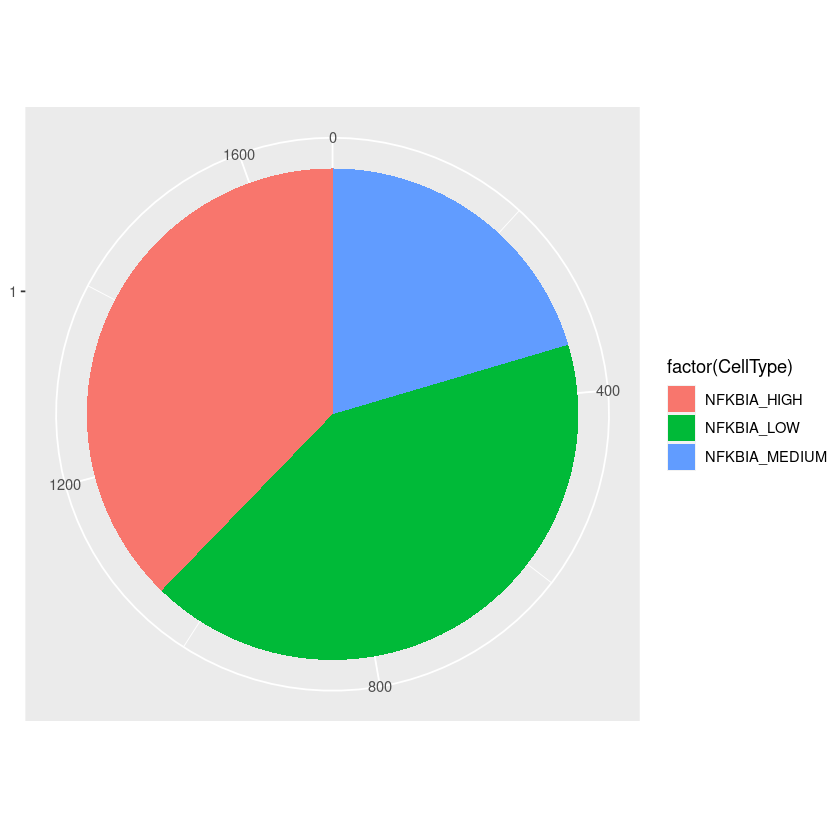

In [41]:
# ggplot graph cell type
library(ggplot2)
pie <- ggplot(pData(cds),
aes(x = factor(1), fill = factor(CellType))) + geom_bar(width = 1)
pie + coord_polar(theta = "y") +
theme(axis.title.x = element_blank(), axis.title.y = element_blank())

Distance cutoff calculated to 3.466849 


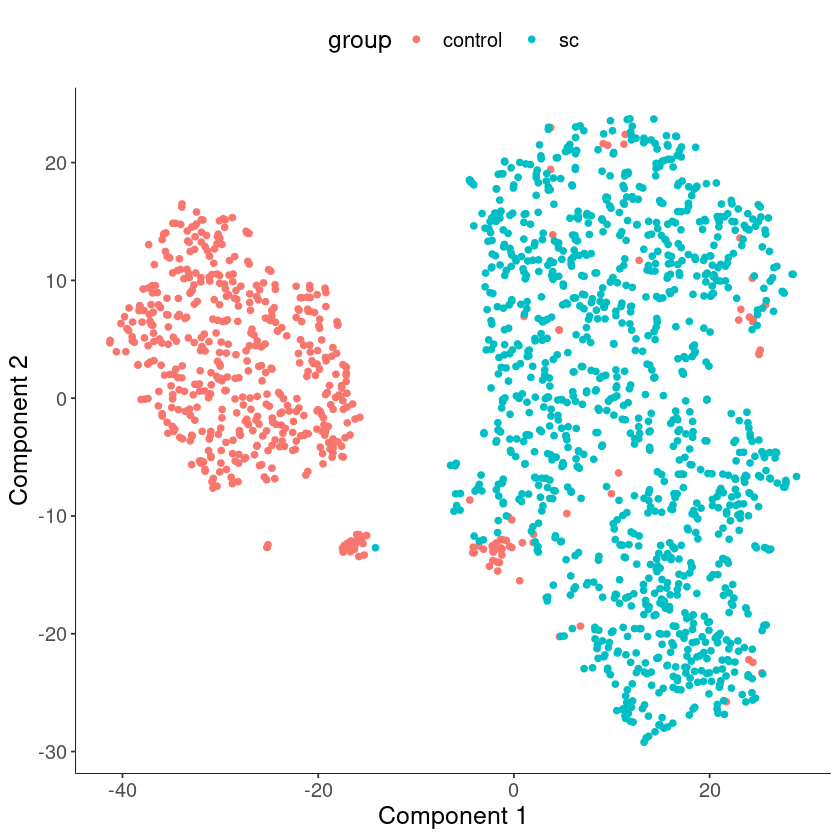

In [45]:
# cluster cells with hiearchy
cds <- clusterCells(cds) 
# plot tsne by cell origin (group): control = healthy donor, sc = severe COVID19
plot_cell_clusters(cds, 1, 2, color = "group")

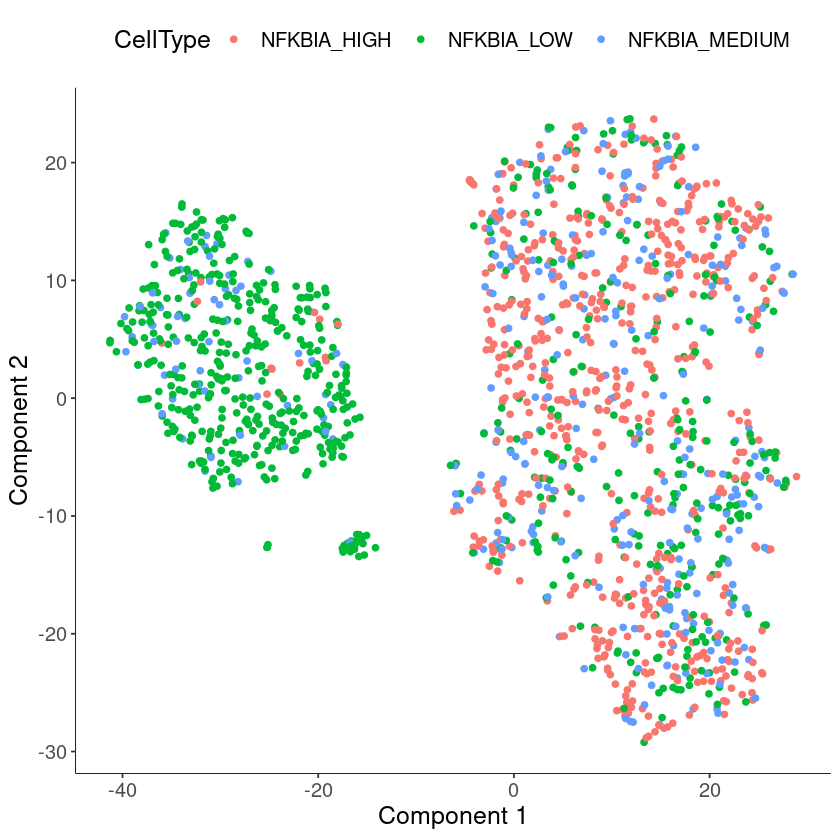

In [46]:
# plot tsne by NFKBIA cell group hierarchy
plot_cell_clusters(cds, 1, 2, color = "CellType")
# nfkbia low cells are mainly in healthy donors samples and NFKBIA medium and high cells are mainly in severe COVID19 samples

In [47]:
# differential expressed genes against cell type
cds <- detectGenes(cds, min_expr = 0.1)
expressed_genes <-  row.names(subset(fData(cds),num_cells_expressed >= 10))
diff_test_res <- differentialGeneTest(cds[expressed_genes,],fullModelFormulaStr = "~CellType")
sig_gene_names <- row.names(subset(diff_test_res, qval < 0.1))
my_ordering_genes <- row.names(diff_test_res)[order(diff_test_res$qval)][1:1000]
cds2 <- setOrderingFilter(cds, ordering_genes = my_ordering_genes)

Warning message in if (isSparseMatrix(exprs(X))) {:
“la condition a une longueur > 1 et seul le premier élément est utilisé”


In [48]:
# dimensional reduction and gene selection
cds2 <- reduceDimension(cds, method = 'DDRTree')
gene_to_cluster <- row.names(diff_test_res)[order(diff_test_res$qval)][1:59] 
conca<-c("NFKBIA",gene_to_cluster)
cds2 <- orderCells(cds2)

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“la condition a une longueur > 1 et seul le premier élément est utilisé”
Warning message 

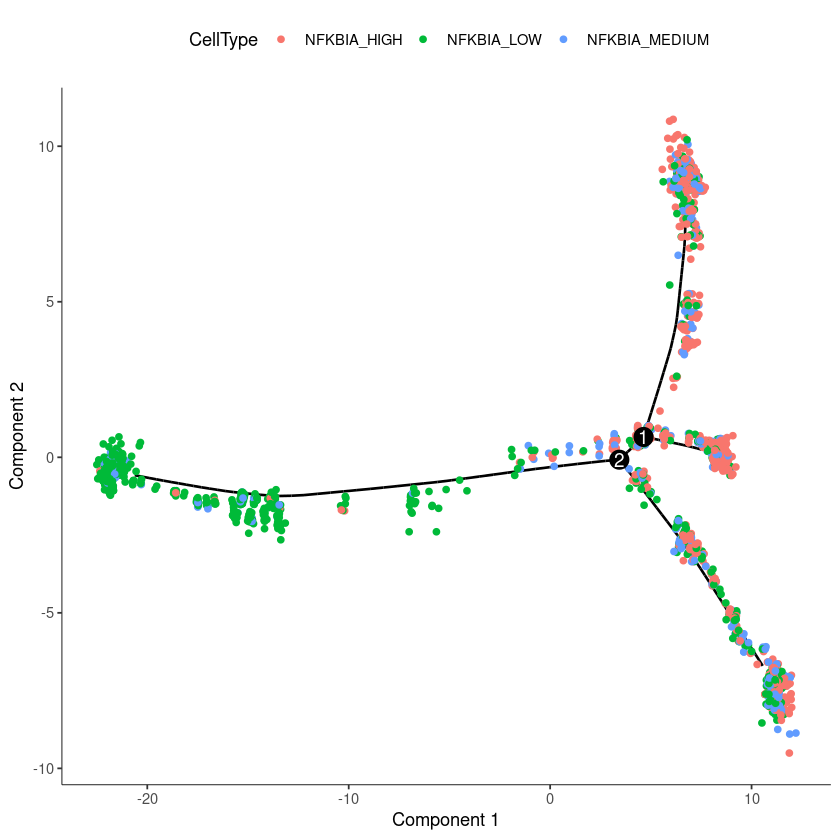

In [50]:
# build graph of clusters on calculated trajectory 
plot_cell_trajectory(cds2, color_by = "CellType")

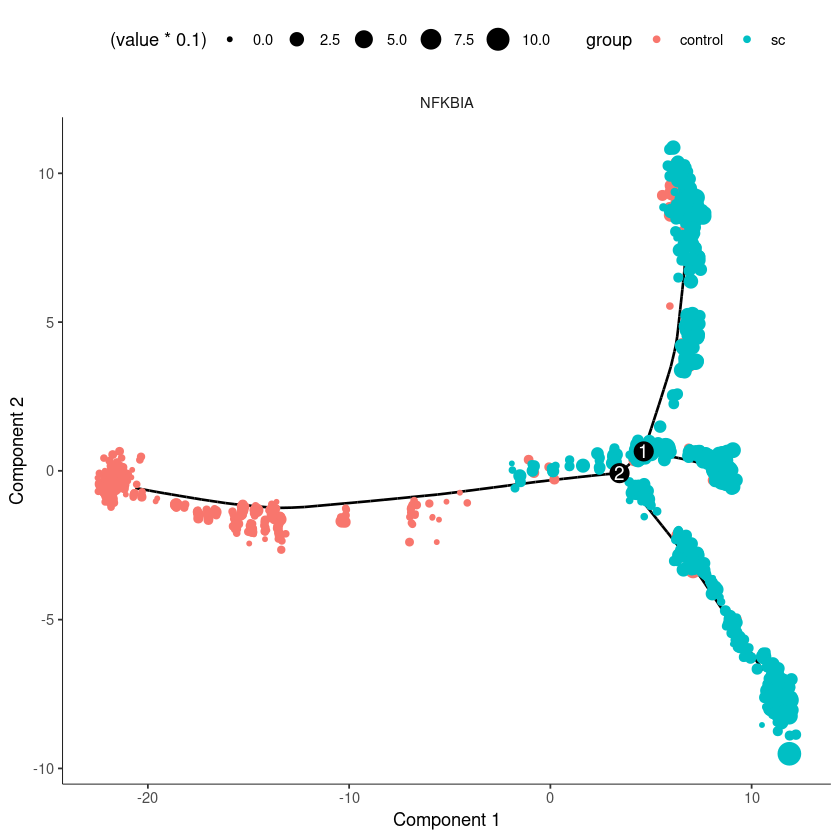

In [53]:
# plot a marker on trajectory with cell group of origin
plot_cell_trajectory(cds2, color_by = "group",markers="NFKBIA",markers_linear = T,show_branch_points=T)

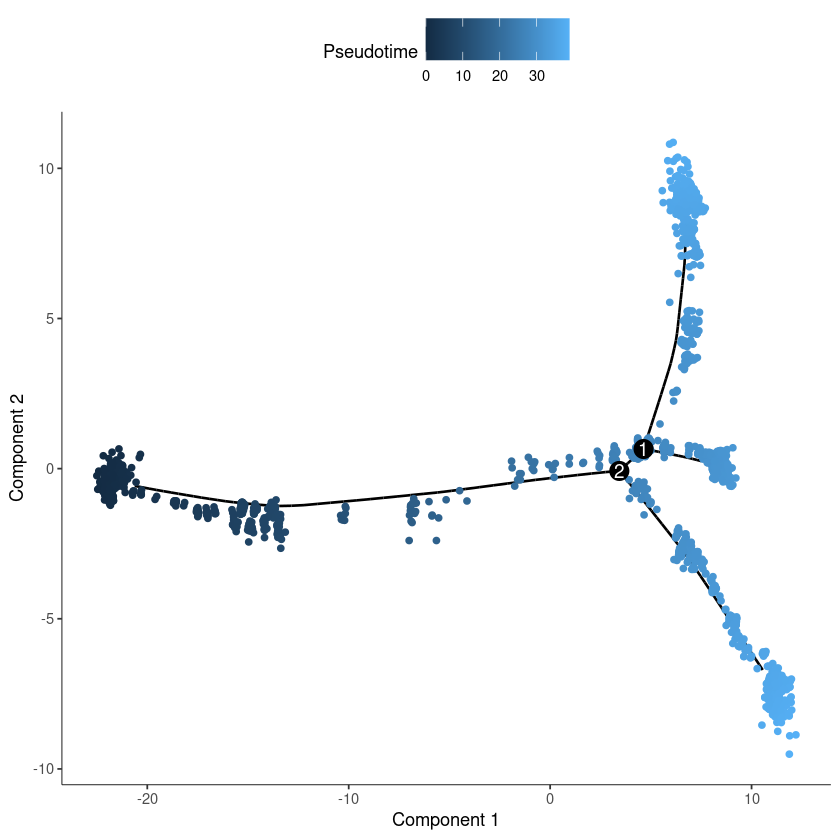

In [54]:
# plot pseudotime on the trajectory
plot_cell_trajectory(cds2, color_by = "Pseudotime")

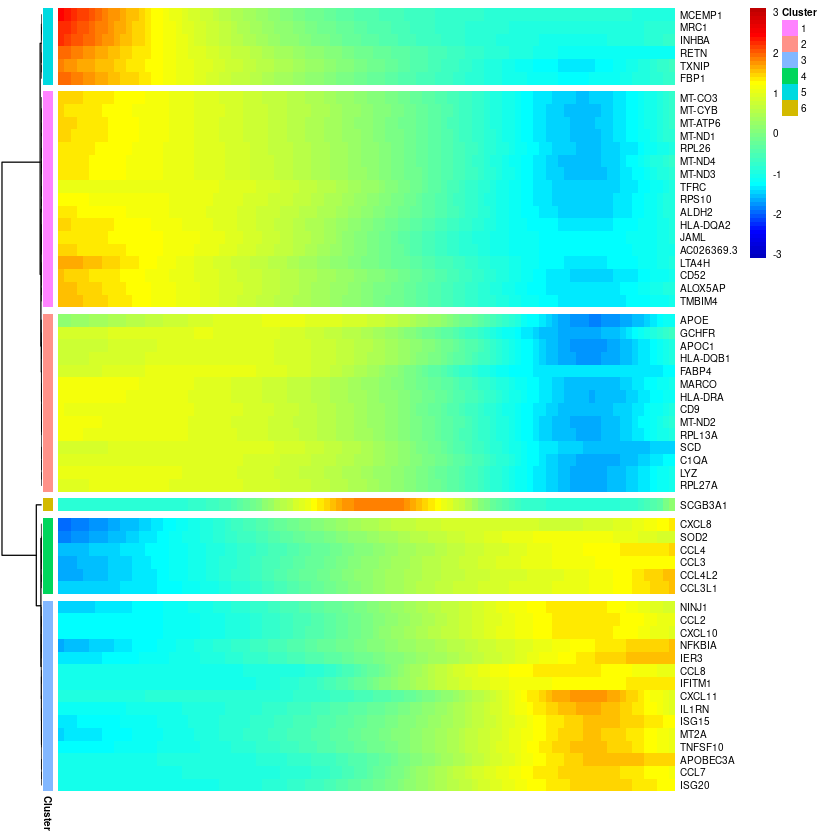

In [56]:
my_pseudotime_cluster <- plot_pseudotime_heatmap(cds2[gene_to_cluster,],cores = 8,
show_rownames = TRUE,return_heatmap = TRUE,cluster_rows = TRUE)

### conclusion : in severe COVID19 broncho alveolar macrophages, the NFKBIA trajectory is connected to the expression of several chemokines like CCL2, CXCL10, CCL8, CXCL11, CCL7.